<a href="https://colab.research.google.com/github/OMGarad/Artificial-Intelligence/blob/main/ModifyMutate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import itertools
import csv


class CNF_Creator:
    def __init__(self,n): #n is number of symbols
        self._n = n
        self._sentence = None

    def _CreateAClause(self):
        n = self._n
        claus = random.sample(range(1,n+1),3)
        for i in range(3):
            claus[i] = -claus[i] if random.choice(range(2))==0 else claus[i]
            #above statement randomly negates some of the literals in the clause
        claus.sort()
        return claus

    def CreateRandomSentence(self,m): #m is number of clauses in the sentence
        n = self._n
        clauses = list()
        while len(clauses)<m:
            for mi in range(len(clauses),m):
                claus = self._CreateAClause()
                clauses.append(claus)
            clauses.sort()
#            print(clauses,len(clauses))
            clauses = list(clause for clause,_ in itertools.groupby(clauses)) # removes duplicate clauses
#            print(clauses,len(clauses))
            self._sentence = clauses
        return self._sentence
    
    """
    def ReadCNFfromCSVfile(self):
        with open('CNF.csv') as csvfile:
            rows = csv.reader(csvfile)
            rows = list(rows)
        sentence = [[int(i) for i in ro] for ro in rows]
        #print(sentence)
        return sentence
    """

def main():
    cnfC = CNF_Creator(n=50) # n is number of symbols 
    sentence = cnfC.CreateRandomSentence(m=350) # m is number of clauses in the sentence
    print(len(sentence))

    #sentence = cnfC.ReadCNFfromCSVfile()
    print(len(sentence))
    

In [5]:
from hashlib import new
from random import betavariate
import time


#Sentence is kept global to allow access to all functions
cnfC = CNF_Creator(n=50) # n is number of symbols in the 3-CNF sentence
sentence= cnfC.CreateRandomSentence(m=100) # m is number of clauses in the 3-CNF sentence  
#sentence = cnfC.ReadCNFfromCSVfile()

def GeneticAlgorithm(population):
    start_time=time.monotonic()   
    frequency=0
    bestValue=0
    iter=0

    arr=random.choices(population,weights=[(fitnessFunction(model)*100)**4 for model in population],k=4)
    arr.sort(key=fitnessFunction,reverse=True)
    bestIndividual=arr[0] #Making bestIndividual the best model out of the sorted array
    while(time.monotonic()-start_time<45 and fitnessFunction(bestIndividual)<1.0 and frequency<50):
        if(iter==0):
            newPopulation=arr[:2] #Initially keeping the best 2 models in the new population
        else:
            newPopulation=population[:2] #Keeping the best 2 models from the previous generation in the current one
        for i in range(len(population)-2):
            x=random.choices(population,weights=[(fitnessFunction(model)*100)**6 for model in population],k=1)[0] #Randomly choosing 2 arrays with weights of their fitness values
            y=random.choices(population,weights=[(fitnessFunction(model)*100)**6 for model in population],k=1)[0] #*100**6 makes the high fintess function values higher and lower ones lower
            
            child=reproduce(x,y) #Reproducing new children using the given arrays
            if(frequency<10):              
                if(random.random()<0.01): #Give a small probability to mutate. 
                    newChild, child= mutate(child)
                    newPopulation.append(newChild)
                    #newChild=mutate(newChild)
                    #newPopulation.append(mutatedChild)
                    #newPopulation.append(mutatedNewChild)
            else:
                if(random.random()<0.5): #If after 10 iterations, the best model isn't found, then we try to mutate it with a higher porbability
                    newChild,child= mutate(child)
                    newPopulation.append(newChild)
                    #newChild=mutate(newChild) #If it gets stuck in a local minima, then get it out by increasing mutation rate.
                    #newPopulation.append(mutatedChild)
                    #newPopulation.append(mutatedNewChild)
            newPopulation.append(child)
        newPopulation.sort(key=fitnessFunction,reverse=True)
        population=newPopulation[:len(population)] #Culling: Taking the best n models after sorting
        bestIndividual=population[0] #bestIndividual is at the first index of population after sorting 
        iter+=1
        #print(fitnessFunction(bestIndividual))
        if(abs(fitnessFunction(bestIndividual)- bestValue)<0.01*bestValue): #If FF value is within 1% of bestValue, then frequency increases
            frequency+=1
        else:
            bestValue=fitnessFunction(bestIndividual)
            frequency=0
        #print(iter)
    return bestIndividual, time.monotonic()-start_time


#Mutating the child by finding the best position for mutation
def mutate(child):
    child=child.copy()
    bestFFindex=-1
    secondbestModel=child
    secondbestFFIndex=bestFFindex
    bestFF=fitnessFunction(child)
    secondbestFF=bestFF
    for i in range(0, 50):
        temp=child
        if(child[i]==True):
            temp[i]=False
        else:
            temp[i]=True
        if(fitnessFunction(temp)>bestFF):
            secondbestFFIndex=bestFFindex
            secondbestFF=bestFF
            bestFFindex=i
            bestFF=fitnessFunction(temp)
    
    if(child[secondbestFFIndex]==True):
        secondbestModel[secondbestFFIndex]=False
    else:
        secondbestModel[secondbestFFIndex]=True
    
    if(bestFFindex<0):
        return child, secondbestModel
    if(child[bestFFindex]==True):
        child[bestFFindex]=False
    else:
        child[bestFFindex]=True

    return child, secondbestModel   

    
#Reproducing with both parents
def reproduce(x,y):
    x=x.copy()
    y=y.copy()
    #secondBestpos=0
    #secondBest=x
    maxFF=0
    maxC=0
    n=len(x)
    for c in range(0,n):
        z= x[:c] + y[c:]
        w= y[:c] + x[c:]
        if(maxFF<fitnessFunction(w) or maxFF<fitnessFunction(z)):
            maxFF= max(fitnessFunction(w), fitnessFunction(z))
            #secondBestpos=maxC
            maxC=c
    
    
    #if(secondBestpos==0):
    #    if(fitnessFunction(y)>fitnessFunction(x)):
    #        secondBest=y
    #    else:
    #        secondBest=x
    
    #else:
    #    p=x[:secondBestpos] + y[secondBestpos:]
    #    q=y[:secondBestpos] + x[secondBestpos:]
    #    if(fitnessFunction(p)>fitnessFunction(q)):
    #        secondBest=p
    #    else:
    #        secondBest=q 
    
    

    childOne= x[:maxC] + y[maxC:]
    childTwo= y[:maxC] + x[maxC:]
    if(fitnessFunction(childOne)>fitnessFunction(childTwo)):
        return childOne#, secondBest
    return childTwo#, secondBest



#Creating population of size k
def createPopulation(k):
    population=[]
    for i in range(0,k):
        model=[]
        for j in range(0,50):
            var= bool(random.getrandbits(1))
            model.append(var)
        population.append(model)
    return population


def fitnessFunction(model):
    numer=0
    denom=len(sentence)
    for i in range(len(sentence)):
        for j in range(0,3):
            num=sentence[i][j]
            if((num>0 and model[num-1]==True) or (num<0 and model[(num*(-1))-1]==False)):
                numer+=1
                break
    
    fitnessValue=numer/denom
    return fitnessValue
    



#cnfC = CNF_Creator(n=50) # n is number of symbols in the 3-CNF sentence
#sentence= cnfC.CreateRandomSentence(m=100) # m is number of clauses in the 3-CNF sentence  
#sentence = cnfC.ReadCNFfromCSVfile()
#print('Random sentence : ',sentence)
#print('\nSentence from CSV file : ',sentence)

k=20

"""
population= createPopulation(k)

optimalModel, timeTaken= GeneticAlgorithm(population)

model=[]
for i in range(len(optimalModel)):
    if(optimalModel[i]==True):
        model.append(i+1)
    else:
        model.append(-(i+1))

#print(model, fitnessFunction(optimalModel)*100, time)
"""

noOfClauses=[100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
avgTimeTaken=[]
avgFFvalue=[]
for i in range(len(noOfClauses)):
    totalTime=0
    totalFF=0
    m=noOfClauses[i]
    for j in range(0,25):
        sentence= cnfC.CreateRandomSentence(m)
        population= createPopulation(k)
        itermodel, itertime= GeneticAlgorithm(population)
        totalFF+=fitnessFunction(itermodel)
        totalTime+=itertime
    print(totalTime)
    print(totalFF)
    avgTimeTaken.append(totalTime/25)
    avgFFvalue.append(totalFF/25)
print("avgFFvalues= ", avgFFvalue)
print("avgTimeTaken= ", avgTimeTaken)


#print('\n\n')
#print('Roll No : 2019A7PS1010G')
#print('Number of clauses in CSV file : ',len(sentence))
#print('Best model : ',model)
#print('Fitness value of best model : ', fitnessFunction(optimalModel)*100, '%')
#print('Time taken : ', timeTaken)
#print('\n\n')



147.2204231110003
24.809999999999995
221.76529419799988
24.74166666666667
313.3865628459994
24.59285714285714
406.88477818299975
24.43125
436.7231377900007
24.42222222222222
523.6233378790002
24.349999999999998
524.3938743070003
24.163636363636368
567.1625490330002
24.116666666666667
622.744951316
24.1076923076923
679.5707428389996
23.939285714285713
768.6757548200003
24.033333333333328
avgFFvalues=  [0.9923999999999998, 0.9896666666666668, 0.9837142857142857, 0.97725, 0.9768888888888888, 0.9739999999999999, 0.9665454545454547, 0.9646666666666667, 0.964307692307692, 0.9575714285714285, 0.9613333333333332]
avgTimeTaken=  [5.888816924440011, 8.870611767919995, 12.535462513839976, 16.275391127319992, 17.468925511600027, 20.94493351516001, 20.97575497228001, 22.68650196132001, 24.90979805264, 27.182829713559986, 30.74703019280001]


In [6]:
import matplotlib.pyplot as plt

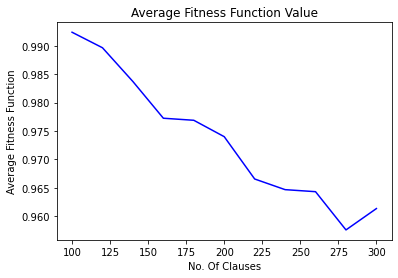

In [7]:
plt.plot(noOfClauses, avgFFvalue, color='blue')
plt.title('Average Fitness Function Value')
plt.xlabel('No. Of Clauses')
plt.ylabel('Average Fitness Function')
plt.show()

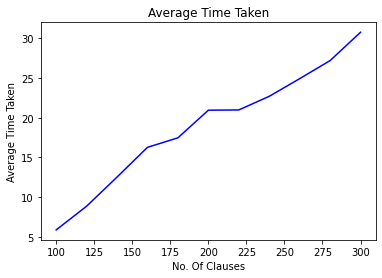

In [8]:
plt.plot(noOfClauses, avgTimeTaken, color='blue')
plt.title('Average Time Taken')
plt.xlabel('No. Of Clauses')
plt.ylabel('Average Time Taken')
plt.show()